## Bootstrap Aggregation of Small Neural Networks
Before utilizing the Twitter data, we will build small neural networks and combining them to an ensemble by bagging, i.e. bootstrap aggregation. For the exploratory data analysis, see the corresponding Jupyter Notebook.

### Loading and Preparing the Data
We start by loading the data and doing some light feature engineering. 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import preprocessing.numerical_data as pnd
%matplotlib inline

In [2]:
df = pd.read_csv(os.path.join("data", "raw", "input.csv"), sep=";", index_col=0, parse_dates=[0], dtype=np.float64)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 994 entries, 2018-11-07 to 2015-01-02
Data columns (total 25 columns):
Open                       988 non-null float64
High                       988 non-null float64
Low                        988 non-null float64
Settle                     994 non-null float64
Change                     984 non-null float64
Volume                     988 non-null float64
Prev. Day Open Interest    993 non-null float64
Gas.Open                   990 non-null float64
Gas.High                   990 non-null float64
Gas.Low                    990 non-null float64
Gas.Settle                 994 non-null float64
Gas.Change                 984 non-null float64
Gas.Volume                 984 non-null float64
Coal.Open                  994 non-null float64
Coal.High                  994 non-null float64
Coal.Low                   994 non-null float64
Coal.Settle                994 non-null float64
Coal.Change                994 non-null float64
Coal.Volume 

We will first apply the transformations that were development during the above mentioned EDA part. In summary, these comprised removing NA values, preventing data leaks by shifting some column values (e.g. shifting the "Settle" columns a day back). Having seen that the price columns seem to follow a log-normal distribution, we transform these by applying the natural logarithm. Please note that I will omit a formal hypothesis test for log-normality, so consider this transformation a heuristic. To avoid issues with logarithms near or at 0, we add 1 to the columns in question. The function $\left[0, \infty\right) \ni x \mapsto \log(1+x)$ maps to $\left[0, \infty\right)$.

In [3]:
df = pnd.chain_preparations(df)

In [4]:
loggable_columns= [col for col in df.columns if any(word in col for word in ("Open", "High", "Low", "Settle"))
                   and not "Interest" in col]
df[loggable_columns] = (df[loggable_columns] + 1).apply(np.log)

c:\program files\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


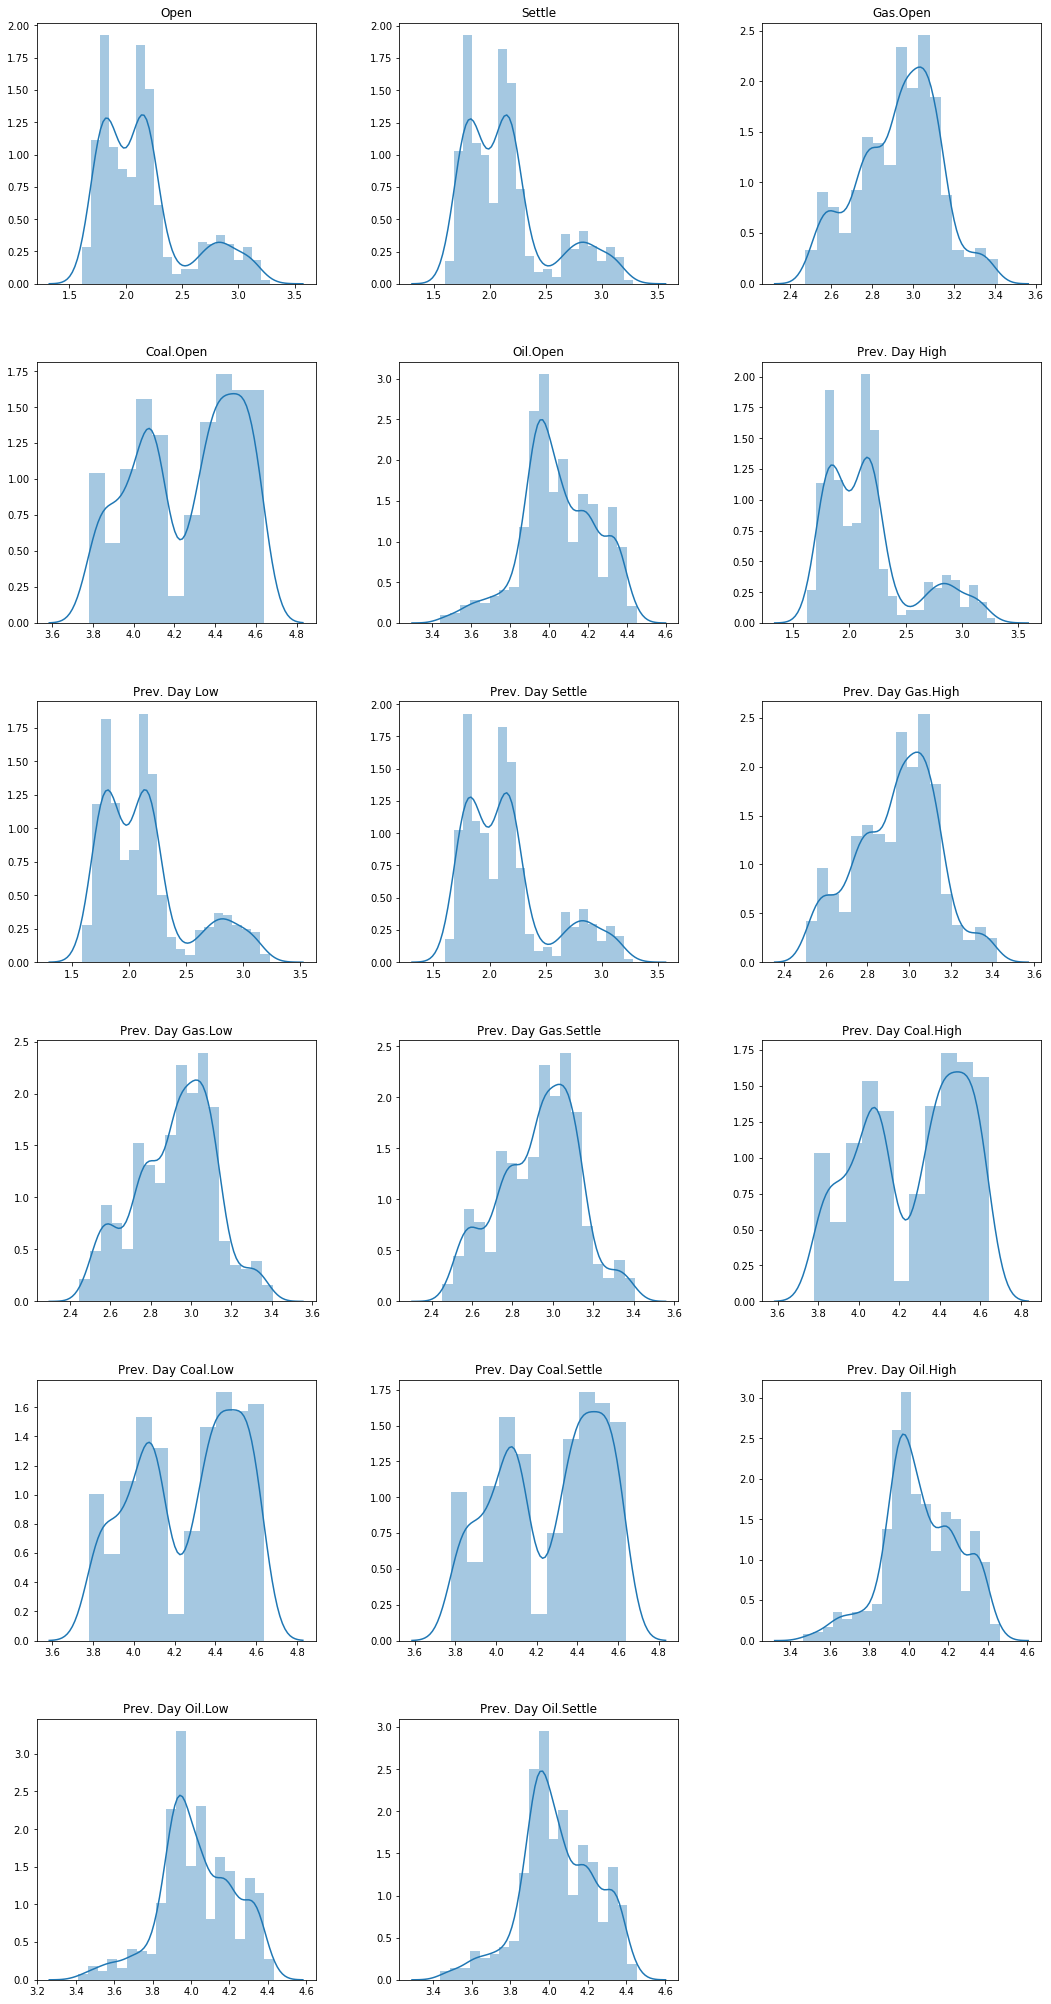

In [5]:
pnd.plot_univariate_distributions(df, loggable_columns, ncols=3)

As seen above, the prior assumption of log-normality was justified at least for Gas and Oil columns. Since no obvious seasonality could be seen during the EDA, we will omit season based feature engineering. 

### Defining the Model
For the model, we use a relatively small Neural Network consisting of two hidden layers. The number of hidden units will be 16 and 8, respectively. To speed up learning, we apply batch normalization after the first hidden layer. Both hidden activations will be rectified linear units (ReLUs). We will optimize with the Adam optimizer and minimize the mean squared error.

In [30]:
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization

def make_model(X, y, optimizer='adam', loss="mse", epochs=500, batch_size=128):
    model = Sequential([
        Dense(16, input_dim=X.shape[1]),
        Activation('relu'),
        BatchNormalization(),
        Dense(8),
        Activation('relu'),
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss=loss)
    model.fit(X, y, epochs=epochs, batch_size=batch_size)
    return model

We transform the data by using a standard scaler, that is, we center the data around mean 0 and scale to achieve variance 1.

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

seed = 123

cols = ['Open', 'Prev. Day Open Interest', 'Gas.Open',
       'Coal.Open', 'Oil.Open', 'Prev. Day High',
       'Prev. Day Low', 'Prev. Day Settle', 'Prev. Day Change',
       'Prev. Day Gas.High', 'Prev. Day Gas.Low', 'Prev. Day Gas.Settle',
       'Prev. Day Gas.Change', 'Prev. Day Coal.High', 'Prev. Day Coal.Low',
       'Prev. Day Coal.Settle', 'Prev. Day Coal.Change', 'Prev. Day Oil.High',
       'Prev. Day Oil.Low', 'Prev. Day Oil.Settle', 'Prev. Day Oil.Change']

X = df[cols].values
y = df["Settle"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

###### The following part should be moved into a class in order to provide more convenient way to assess the model's performance and to obtain predictions

In [39]:
num_models = 10
models = [make_model(X_train[selection], y_train[selection], epochs=1000)
          for selection in [np.random.choice(np.arange(len(X_train)), len(X_train)) for _ in range(num_models)]]

Epoch 1/1000
778/778 [==============================] - 1s 653us/step - loss: 4.9476
Epoch 2/1000
778/778 [==============================] - 0s 19us/step - loss: 4.2652
Epoch 3/1000
778/778 [==============================] - 0s 19us/step - loss: 3.6701
Epoch 4/1000
778/778 [==============================] - 0s 19us/step - loss: 3.1586
Epoch 5/1000
778/778 [==============================] - 0s 14us/step - loss: 2.7368
Epoch 6/1000
778/778 [==============================] - 0s 19us/step - loss: 2.3802
Epoch 7/1000
778/778 [==============================] - 0s 17us/step - loss: 2.0492
Epoch 8/1000
778/778 [==============================] - 0s 19us/step - loss: 1.7887
Epoch 9/1000
778/778 [==============================] - 0s 18us/step - loss: 1.5633
Epoch 10/1000
778/778 [==============================] - 0s 15us/step - loss: 1.3693
Epoch 11/1000
778/778 [==============================] - 0s 12us/step - loss: 1.2162
Epoch 12/1000
778/778 [==============================] - 0s 13us/step - l

778/778 [==============================] - 0s 13us/step - loss: 0.0377
Epoch 98/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0381
Epoch 99/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0394
Epoch 100/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0363
Epoch 101/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0369
Epoch 102/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0353
Epoch 103/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0444
Epoch 104/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0356
Epoch 105/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0345
Epoch 106/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0352
Epoch 107/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0376
Epoch 108/1000
778/778 [==============================] - 0s 12us/step 

778/778 [==============================] - 0s 15us/step - loss: 0.0200
Epoch 193/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0245
Epoch 194/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0199
Epoch 195/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0199
Epoch 196/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0212
Epoch 197/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0165
Epoch 198/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0175
Epoch 199/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0205
Epoch 200/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0222
Epoch 201/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0119
Epoch 202/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0150
Epoch 203/1000
778/778 [==============================] - 0s 15us/ste

778/778 [==============================] - 0s 15us/step - loss: 0.0180
Epoch 288/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0150
Epoch 289/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0153
Epoch 290/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0093
Epoch 291/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0141
Epoch 292/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0121
Epoch 293/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0104
Epoch 294/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0133
Epoch 295/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0113
Epoch 296/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0121
Epoch 297/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0139
Epoch 298/1000
778/778 [==============================] - 0s 14us/ste

778/778 [==============================] - 0s 10us/step - loss: 0.0096
Epoch 383/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0117
Epoch 384/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0072
Epoch 385/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0093
Epoch 386/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0113
Epoch 387/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0074
Epoch 388/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0100
Epoch 389/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0089
Epoch 390/1000
778/778 [==============================] - 0s 22us/step - loss: 0.0065
Epoch 391/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0117
Epoch 392/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0086
Epoch 393/1000
778/778 [==============================] - 0s 10us/ste

778/778 [==============================] - 0s 18us/step - loss: 0.0142
Epoch 478/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0096
Epoch 479/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0070
Epoch 480/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0090
Epoch 481/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0094
Epoch 482/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0058
Epoch 483/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0090
Epoch 484/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0076
Epoch 485/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0050
Epoch 486/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0044
Epoch 487/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0073
Epoch 488/1000
778/778 [==============================] - 0s 10us/ste

778/778 [==============================] - 0s 13us/step - loss: 0.0058
Epoch 573/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0061
Epoch 574/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0064
Epoch 575/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0062
Epoch 576/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0059
Epoch 577/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0039
Epoch 578/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0064
Epoch 579/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0094
Epoch 580/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0072
Epoch 581/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0067
Epoch 582/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0052
Epoch 583/1000
778/778 [==============================] - 0s 14us/ste

778/778 [==============================] - 0s 14us/step - loss: 0.0039
Epoch 668/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0028
Epoch 669/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0047
Epoch 670/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0052
Epoch 671/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0070
Epoch 672/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0053
Epoch 673/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0044
Epoch 674/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0037
Epoch 675/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0048
Epoch 676/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0053
Epoch 677/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0051
Epoch 678/1000
778/778 [==============================] - 0s 15us/ste

778/778 [==============================] - 0s 15us/step - loss: 0.0031
Epoch 763/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0036
Epoch 764/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0044
Epoch 765/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0071
Epoch 766/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0052
Epoch 767/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0038
Epoch 768/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0037
Epoch 769/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0024
Epoch 770/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0028
Epoch 771/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0059
Epoch 772/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0028
Epoch 773/1000
778/778 [==============================] - 0s 14us/ste

778/778 [==============================] - 0s 13us/step - loss: 0.0025
Epoch 858/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0034
Epoch 859/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0024
Epoch 860/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0029
Epoch 861/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0036
Epoch 862/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0032
Epoch 863/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0032
Epoch 864/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0031
Epoch 865/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0025
Epoch 866/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0024
Epoch 867/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0025
Epoch 868/1000
778/778 [==============================] - 0s 14us/ste

778/778 [==============================] - 0s 9us/step - loss: 0.0026
Epoch 953/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0040
Epoch 954/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0024
Epoch 955/1000
778/778 [==============================] - ETA: 0s - loss: 0.001 - 0s 12us/step - loss: 0.0018
Epoch 956/1000
778/778 [==============================] - 0s 16us/step - loss: 0.0032
Epoch 957/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0026
Epoch 958/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0032
Epoch 959/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0020
Epoch 960/1000
778/778 [==============================] - 0s 27us/step - loss: 0.0028
Epoch 961/1000
778/778 [==============================] - 0s 22us/step - loss: 0.0032
Epoch 962/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0024
Epoch 963/1000
778/778 [======================

778/778 [==============================] - 0s 10us/step - loss: 0.6617
Epoch 48/1000
778/778 [==============================] - 0s 14us/step - loss: 0.6204
Epoch 49/1000
778/778 [==============================] - 0s 10us/step - loss: 0.5929
Epoch 50/1000
778/778 [==============================] - 0s 13us/step - loss: 0.5560
Epoch 51/1000
778/778 [==============================] - 0s 10us/step - loss: 0.5452
Epoch 52/1000
778/778 [==============================] - 0s 12us/step - loss: 0.5089
Epoch 53/1000
778/778 [==============================] - 0s 12us/step - loss: 0.4907
Epoch 54/1000
778/778 [==============================] - 0s 10us/step - loss: 0.4705
Epoch 55/1000
778/778 [==============================] - 0s 12us/step - loss: 0.4563
Epoch 56/1000
778/778 [==============================] - 0s 12us/step - loss: 0.4302
Epoch 57/1000
778/778 [==============================] - 0s 14us/step - loss: 0.4127
Epoch 58/1000
778/778 [==============================] - 0s 13us/step - loss: 0

778/778 [==============================] - 0s 12us/step - loss: 0.0261
Epoch 144/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0197
Epoch 145/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0266
Epoch 146/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0271
Epoch 147/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0203
Epoch 148/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0238
Epoch 149/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0213
Epoch 150/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0320
Epoch 151/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0185
Epoch 152/1000
778/778 [==============================] - 0s 9us/step - loss: 0.0203
Epoch 153/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0251
Epoch 154/1000
778/778 [==============================] - 0s 13us/step

778/778 [==============================] - 0s 13us/step - loss: 0.0141
Epoch 239/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0157
Epoch 240/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0121
Epoch 241/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0125
Epoch 242/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0164
Epoch 243/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0139
Epoch 244/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0123
Epoch 245/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0196
Epoch 246/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0137
Epoch 247/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0092
Epoch 248/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0142
Epoch 249/1000
778/778 [==============================] - 0s 12us/ste

778/778 [==============================] - 0s 13us/step - loss: 0.0094
Epoch 334/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0096
Epoch 335/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0087
Epoch 336/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0125
Epoch 337/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0100
Epoch 338/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0109
Epoch 339/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0126
Epoch 340/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0108
Epoch 341/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0167
Epoch 342/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0089
Epoch 343/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0125
Epoch 344/1000
778/778 [==============================] - 0s 14us/ste

778/778 [==============================] - 0s 12us/step - loss: 0.0055
Epoch 429/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0075
Epoch 430/1000
778/778 [==============================] - ETA: 0s - loss: 0.008 - 0s 10us/step - loss: 0.0087
Epoch 431/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0074
Epoch 432/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0092
Epoch 433/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0095
Epoch 434/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0077
Epoch 435/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0074
Epoch 436/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0092
Epoch 437/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0073
Epoch 438/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0056
Epoch 439/1000
778/778 [=====================

778/778 [==============================] - 0s 12us/step - loss: 0.0062
Epoch 524/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0106
Epoch 525/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0053
Epoch 526/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0068
Epoch 527/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0072
Epoch 528/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0061
Epoch 529/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0048
Epoch 530/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0052
Epoch 531/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0089
Epoch 532/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0048
Epoch 533/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0054
Epoch 534/1000
778/778 [==============================] - 0s 12us/ste

778/778 [==============================] - 0s 10us/step - loss: 0.0058
Epoch 619/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0038
Epoch 620/1000
778/778 [==============================] - 0s 9us/step - loss: 0.0049
Epoch 621/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0043
Epoch 622/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0050
Epoch 623/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0038
Epoch 624/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0060
Epoch 625/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0037
Epoch 626/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0053
Epoch 627/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0045
Epoch 628/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0041
Epoch 629/1000
778/778 [==============================] - 0s 13us/step

778/778 [==============================] - 0s 12us/step - loss: 0.0051
Epoch 714/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0037
Epoch 715/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0052
Epoch 716/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0047
Epoch 717/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0038
Epoch 718/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0045
Epoch 719/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0038
Epoch 720/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0032
Epoch 721/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0035
Epoch 722/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0039
Epoch 723/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0033
Epoch 724/1000
778/778 [==============================] - 0s 10us/ste

778/778 [==============================] - 0s 13us/step - loss: 0.0027
Epoch 809/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0022
Epoch 810/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0027
Epoch 811/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0026
Epoch 812/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0027
Epoch 813/1000
778/778 [==============================] - 0s 21us/step - loss: 0.0032
Epoch 814/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0024
Epoch 815/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0045
Epoch 816/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0033
Epoch 817/1000
778/778 [==============================] - 0s 22us/step - loss: 0.0028
Epoch 818/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0031
Epoch 819/1000
778/778 [==============================] - 0s 21us/ste

778/778 [==============================] - 0s 14us/step - loss: 0.0022
Epoch 904/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0028
Epoch 905/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0019
Epoch 906/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0023
Epoch 907/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0020
Epoch 908/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0022
Epoch 909/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0023
Epoch 910/1000
778/778 [==============================] - 0s 16us/step - loss: 0.0025
Epoch 911/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0025
Epoch 912/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0036
Epoch 913/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0025
Epoch 914/1000
778/778 [==============================] - 0s 10us/ste

778/778 [==============================] - 0s 13us/step - loss: 0.0024
Epoch 999/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0020
Epoch 1000/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0036
Epoch 1/1000
778/778 [==============================] - 1s 958us/step - loss: 9.0836
Epoch 2/1000
778/778 [==============================] - 0s 22us/step - loss: 7.5762
Epoch 3/1000
778/778 [==============================] - 0s 18us/step - loss: 6.4753
Epoch 4/1000
778/778 [==============================] - 0s 17us/step - loss: 5.5235
Epoch 5/1000
778/778 [==============================] - 0s 18us/step - loss: 4.7528
Epoch 6/1000
778/778 [==============================] - 0s 14us/step - loss: 4.0961
Epoch 7/1000
778/778 [==============================] - 0s 17us/step - loss: 3.5542
Epoch 8/1000
778/778 [==============================] - 0s 15us/step - loss: 3.1388
Epoch 9/1000
778/778 [==============================] - 0s 17us/step - loss: 2.7960

778/778 [==============================] - 0s 14us/step - loss: 0.0460
Epoch 95/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0355
Epoch 96/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0515
Epoch 97/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0445
Epoch 98/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0477
Epoch 99/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0408
Epoch 100/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0386
Epoch 101/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0513
Epoch 102/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0323
Epoch 103/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0316
Epoch 104/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0352
Epoch 105/1000
778/778 [==============================] - 0s 14us/step - l

778/778 [==============================] - 0s 14us/step - loss: 0.0290
Epoch 190/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0196
Epoch 191/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0188
Epoch 192/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0193
Epoch 193/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0267
Epoch 194/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0142
Epoch 195/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0171
Epoch 196/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0199
Epoch 197/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0350
Epoch 198/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0187
Epoch 199/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0160
Epoch 200/1000
778/778 [==============================] - 0s 17us/ste

778/778 [==============================] - 0s 14us/step - loss: 0.0239
Epoch 285/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0193
Epoch 286/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0187
Epoch 287/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0159
Epoch 288/1000
778/778 [==============================] - 0s 11us/step - loss: 0.0110
Epoch 289/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0125
Epoch 290/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0110
Epoch 291/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0130
Epoch 292/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0111
Epoch 293/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0141
Epoch 294/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0112
Epoch 295/1000
778/778 [==============================] - 0s 14us/ste

778/778 [==============================] - 0s 15us/step - loss: 0.0165
Epoch 380/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0117
Epoch 381/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0081
Epoch 382/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0113
Epoch 383/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0094
Epoch 384/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0102
Epoch 385/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0161
Epoch 386/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0083
Epoch 387/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0093
Epoch 388/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0126
Epoch 389/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0100
Epoch 390/1000
778/778 [==============================] - 0s 13us/ste

778/778 [==============================] - 0s 13us/step - loss: 0.0080
Epoch 475/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0091
Epoch 476/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0115
Epoch 477/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0088
Epoch 478/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0064
Epoch 479/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0088
Epoch 480/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0105
Epoch 481/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0100
Epoch 482/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0070
Epoch 483/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0096
Epoch 484/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0085
Epoch 485/1000
778/778 [==============================] - 0s 14us/ste

778/778 [==============================] - 0s 12us/step - loss: 0.0068
Epoch 570/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0080
Epoch 571/1000
778/778 [==============================] - 0s 16us/step - loss: 0.0061
Epoch 572/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0078
Epoch 573/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0065
Epoch 574/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0063
Epoch 575/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0108
Epoch 576/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0079
Epoch 577/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0093
Epoch 578/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0091
Epoch 579/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0067
Epoch 580/1000
778/778 [==============================] - 0s 13us/ste

778/778 [==============================] - 0s 13us/step - loss: 0.0055
Epoch 665/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0058
Epoch 666/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0063
Epoch 667/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0062
Epoch 668/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0051
Epoch 669/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0045
Epoch 670/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0040
Epoch 671/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0065
Epoch 672/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0049
Epoch 673/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0053
Epoch 674/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0056
Epoch 675/1000
778/778 [==============================] - 0s 13us/ste

778/778 [==============================] - 0s 17us/step - loss: 0.0045
Epoch 760/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0040
Epoch 761/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0044
Epoch 762/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0042
Epoch 763/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0040
Epoch 764/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0051
Epoch 765/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0048
Epoch 766/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0045
Epoch 767/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0037
Epoch 768/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0038
Epoch 769/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0045
Epoch 770/1000
778/778 [==============================] - 0s 15us/ste

778/778 [==============================] - 0s 13us/step - loss: 0.0028
Epoch 855/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0041
Epoch 856/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0038
Epoch 857/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0038
Epoch 858/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0040
Epoch 859/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0035
Epoch 860/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0035
Epoch 861/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0036
Epoch 862/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0051
Epoch 863/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0039
Epoch 864/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0033
Epoch 865/1000
778/778 [==============================] - 0s 15us/ste

778/778 [==============================] - 0s 17us/step - loss: 0.0040
Epoch 950/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0040
Epoch 951/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0028
Epoch 952/1000
778/778 [==============================] - 0s 22us/step - loss: 0.0042
Epoch 953/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0024
Epoch 954/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0026
Epoch 955/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0026
Epoch 956/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0027
Epoch 957/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0028
Epoch 958/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0025
Epoch 959/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0026
Epoch 960/1000
778/778 [==============================] - 0s 14us/ste

778/778 [==============================] - 0s 24us/step - loss: 0.0738
Epoch 45/1000
778/778 [==============================] - 0s 27us/step - loss: 0.0678
Epoch 46/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0665
Epoch 47/1000
778/778 [==============================] - 0s 24us/step - loss: 0.0659
Epoch 48/1000
778/778 [==============================] - 0s 23us/step - loss: 0.0695
Epoch 49/1000
778/778 [==============================] - 0s 22us/step - loss: 0.0593
Epoch 50/1000
778/778 [==============================] - 0s 26us/step - loss: 0.0611
Epoch 51/1000
778/778 [==============================] - 0s 23us/step - loss: 0.0547
Epoch 52/1000
778/778 [==============================] - 0s 24us/step - loss: 0.0600
Epoch 53/1000
778/778 [==============================] - 0s 22us/step - loss: 0.0547
Epoch 54/1000
778/778 [==============================] - 0s 23us/step - loss: 0.0561
Epoch 55/1000
778/778 [==============================] - 0s 22us/step - loss: 0

778/778 [==============================] - 0s 31us/step - loss: 0.0178
Epoch 140/1000
778/778 [==============================] - 0s 26us/step - loss: 0.0203
Epoch 141/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0191
Epoch 142/1000
778/778 [==============================] - 0s 29us/step - loss: 0.0194
Epoch 143/1000
778/778 [==============================] - 0s 37us/step - loss: 0.0148
Epoch 144/1000
778/778 [==============================] - 0s 32us/step - loss: 0.0327
Epoch 145/1000
778/778 [==============================] - 0s 27us/step - loss: 0.0217
Epoch 146/1000
778/778 [==============================] - 0s 26us/step - loss: 0.0211
Epoch 147/1000
778/778 [==============================] - 0s 33us/step - loss: 0.0251
Epoch 148/1000
778/778 [==============================] - 0s 22us/step - loss: 0.0249
Epoch 149/1000
778/778 [==============================] - 0s 26us/step - loss: 0.0187
Epoch 150/1000
778/778 [==============================] - 0s 19us/ste

778/778 [==============================] - 0s 17us/step - loss: 0.0112
Epoch 235/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0111
Epoch 236/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0132
Epoch 237/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0148
Epoch 238/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0137
Epoch 239/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0138
Epoch 240/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0138
Epoch 241/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0141
Epoch 242/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0130
Epoch 243/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0126
Epoch 244/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0118
Epoch 245/1000
778/778 [==============================] - 0s 15us/ste

778/778 [==============================] - 0s 17us/step - loss: 0.0154
Epoch 330/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0098
Epoch 331/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0131
Epoch 332/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0067
Epoch 333/1000
778/778 [==============================] - 0s 22us/step - loss: 0.0109
Epoch 334/1000
778/778 [==============================] - 0s 24us/step - loss: 0.0137
Epoch 335/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0094
Epoch 336/1000
778/778 [==============================] - 0s 22us/step - loss: 0.0100
Epoch 337/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0104
Epoch 338/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0088
Epoch 339/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0102
Epoch 340/1000
778/778 [==============================] - 0s 18us/ste

778/778 [==============================] - 0s 12us/step - loss: 0.0075
Epoch 425/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0089
Epoch 426/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0094
Epoch 427/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0117
Epoch 428/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0080
Epoch 429/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0102
Epoch 430/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0062
Epoch 431/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0058
Epoch 432/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0066
Epoch 433/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0093
Epoch 434/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0061
Epoch 435/1000
778/778 [==============================] - 0s 15us/ste

778/778 [==============================] - 0s 14us/step - loss: 0.0064
Epoch 520/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0062
Epoch 521/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0084
Epoch 522/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0064
Epoch 523/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0046
Epoch 524/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0047
Epoch 525/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0052
Epoch 526/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0043
Epoch 527/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0062
Epoch 528/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0073
Epoch 529/1000
778/778 [==============================] - 0s 26us/step - loss: 0.0059
Epoch 530/1000
778/778 [==============================] - 0s 24us/ste

778/778 [==============================] - 0s 14us/step - loss: 0.0059
Epoch 615/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0048
Epoch 616/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0055
Epoch 617/1000
778/778 [==============================] - 0s 22us/step - loss: 0.0065
Epoch 618/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0049
Epoch 619/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0053
Epoch 620/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0049
Epoch 621/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0038
Epoch 622/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0051
Epoch 623/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0047
Epoch 624/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0054
Epoch 625/1000
778/778 [==============================] - 0s 19us/ste

778/778 [==============================] - 0s 17us/step - loss: 0.0043
Epoch 710/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0048
Epoch 711/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0042
Epoch 712/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0037
Epoch 713/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0042
Epoch 714/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0063
Epoch 715/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0045
Epoch 716/1000
778/778 [==============================] - 0s 21us/step - loss: 0.0035
Epoch 717/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0040
Epoch 718/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0031
Epoch 719/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0043
Epoch 720/1000
778/778 [==============================] - 0s 15us/ste

778/778 [==============================] - 0s 18us/step - loss: 0.0034
Epoch 805/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0032
Epoch 806/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0026
Epoch 807/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0033
Epoch 808/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0022
Epoch 809/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0029
Epoch 810/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0034
Epoch 811/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0034
Epoch 812/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0033
Epoch 813/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0030
Epoch 814/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0024
Epoch 815/1000
778/778 [==============================] - 0s 15us/ste

778/778 [==============================] - 0s 12us/step - loss: 0.0067
Epoch 900/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0048
Epoch 901/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0050
Epoch 902/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0038
Epoch 903/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0033
Epoch 904/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0028
Epoch 905/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0020
Epoch 906/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0031
Epoch 907/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0027
Epoch 908/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0033
Epoch 909/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0025
Epoch 910/1000
778/778 [==============================] - 0s 14us/ste

778/778 [==============================] - 0s 12us/step - loss: 0.0016
Epoch 995/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0022
Epoch 996/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0017
Epoch 997/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0017
Epoch 998/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0016
Epoch 999/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0022
Epoch 1000/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0023
Epoch 1/1000
778/778 [==============================] - 1s 947us/step - loss: 5.1055
Epoch 2/1000
778/778 [==============================] - 0s 17us/step - loss: 4.5056
Epoch 3/1000
778/778 [==============================] - 0s 17us/step - loss: 3.9795
Epoch 4/1000
778/778 [==============================] - 0s 14us/step - loss: 3.5329
Epoch 5/1000
778/778 [==============================] - 0s 18us/step - loss

778/778 [==============================] - 0s 15us/step - loss: 0.0246
Epoch 91/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0327
Epoch 92/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0201
Epoch 93/1000
778/778 [==============================] - 0s 16us/step - loss: 0.0214
Epoch 94/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0239
Epoch 95/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0295
Epoch 96/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0255
Epoch 97/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0207
Epoch 98/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0239
Epoch 99/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0287
Epoch 100/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0176
Epoch 101/1000
778/778 [==============================] - 0s 15us/step - loss:

778/778 [==============================] - 0s 15us/step - loss: 0.0178
Epoch 186/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0219
Epoch 187/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0180
Epoch 188/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0216
Epoch 189/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0163
Epoch 190/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0218
Epoch 191/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0167
Epoch 192/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0188
Epoch 193/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0137
Epoch 194/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0165
Epoch 195/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0147
Epoch 196/1000
778/778 [==============================] - 0s 15us/ste

778/778 [==============================] - 0s 14us/step - loss: 0.0145
Epoch 281/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0122
Epoch 282/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0109
Epoch 283/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0128
Epoch 284/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0160
Epoch 285/1000
778/778 [==============================] - 0s 28us/step - loss: 0.0113
Epoch 286/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0170
Epoch 287/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0105
Epoch 288/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0100
Epoch 289/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0104
Epoch 290/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0121
Epoch 291/1000
778/778 [==============================] - 0s 17us/ste

778/778 [==============================] - 0s 14us/step - loss: 0.0070
Epoch 376/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0076
Epoch 377/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0091
Epoch 378/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0074
Epoch 379/1000
778/778 [==============================] - 0s 21us/step - loss: 0.0104
Epoch 380/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0103
Epoch 381/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0182
Epoch 382/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0101
Epoch 383/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0097
Epoch 384/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0099
Epoch 385/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0086
Epoch 386/1000
778/778 [==============================] - 0s 17us/ste

778/778 [==============================] - 0s 15us/step - loss: 0.0086
Epoch 471/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0065
Epoch 472/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0126
Epoch 473/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0075
Epoch 474/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0099
Epoch 475/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0096
Epoch 476/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0078
Epoch 477/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0076
Epoch 478/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0084
Epoch 479/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0068
Epoch 480/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0076
Epoch 481/1000
778/778 [==============================] - 0s 14us/ste

778/778 [==============================] - 0s 17us/step - loss: 0.0052
Epoch 566/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0045
Epoch 567/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0066
Epoch 568/1000
778/778 [==============================] - 0s 21us/step - loss: 0.0065
Epoch 569/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0064
Epoch 570/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0066
Epoch 571/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0051
Epoch 572/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0084
Epoch 573/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0042
Epoch 574/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0064
Epoch 575/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0054
Epoch 576/1000
778/778 [==============================] - 0s 17us/ste

778/778 [==============================] - 0s 14us/step - loss: 0.0058
Epoch 661/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0036
Epoch 662/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0047
Epoch 663/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0056
Epoch 664/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0040
Epoch 665/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0058
Epoch 666/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0036
Epoch 667/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0051
Epoch 668/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0069
Epoch 669/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0046
Epoch 670/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0078
Epoch 671/1000
778/778 [==============================] - 0s 15us/ste

778/778 [==============================] - 0s 15us/step - loss: 0.0038
Epoch 756/1000
778/778 [==============================] - 0s 21us/step - loss: 0.0034
Epoch 757/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0048
Epoch 758/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0037
Epoch 759/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0054
Epoch 760/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0038
Epoch 761/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0040
Epoch 762/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0056
Epoch 763/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0051
Epoch 764/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0042
Epoch 765/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0044
Epoch 766/1000
778/778 [==============================] - 0s 14us/ste

778/778 [==============================] - 0s 14us/step - loss: 0.0043
Epoch 851/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0023
Epoch 852/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0049
Epoch 853/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0028
Epoch 854/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0027
Epoch 855/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0036
Epoch 856/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0030
Epoch 857/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0036
Epoch 858/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0035
Epoch 859/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0043
Epoch 860/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0041
Epoch 861/1000
778/778 [==============================] - 0s 17us/ste

778/778 [==============================] - 0s 17us/step - loss: 0.0028
Epoch 946/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0027
Epoch 947/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0027
Epoch 948/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0026
Epoch 949/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0031
Epoch 950/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0029
Epoch 951/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0029
Epoch 952/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0033
Epoch 953/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0025
Epoch 954/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0031
Epoch 955/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0026
Epoch 956/1000
778/778 [==============================] - 0s 13us/ste

Epoch 41/1000
778/778 [==============================] - 0s 13us/step - loss: 0.2700
Epoch 42/1000
778/778 [==============================] - 0s 17us/step - loss: 0.2772
Epoch 43/1000
778/778 [==============================] - 0s 14us/step - loss: 0.2320
Epoch 44/1000
778/778 [==============================] - 0s 17us/step - loss: 0.2490
Epoch 45/1000
778/778 [==============================] - 0s 12us/step - loss: 0.2238
Epoch 46/1000
778/778 [==============================] - 0s 15us/step - loss: 0.2181
Epoch 47/1000
778/778 [==============================] - 0s 15us/step - loss: 0.2176
Epoch 48/1000
778/778 [==============================] - 0s 10us/step - loss: 0.2032
Epoch 49/1000
778/778 [==============================] - 0s 15us/step - loss: 0.1880
Epoch 50/1000
778/778 [==============================] - 0s 15us/step - loss: 0.1770
Epoch 51/1000
778/778 [==============================] - 0s 12us/step - loss: 0.1883
Epoch 52/1000
778/778 [==============================] - 0s 13us/

Epoch 137/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0339
Epoch 138/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0292
Epoch 139/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0363
Epoch 140/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0256
Epoch 141/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0278
Epoch 142/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0329
Epoch 143/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0281
Epoch 144/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0285
Epoch 145/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0477
Epoch 146/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0339
Epoch 147/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0266
Epoch 148/1000
778/778 [==============================

778/778 [==============================] - 0s 15us/step - loss: 0.0160
Epoch 233/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0144
Epoch 234/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0141
Epoch 235/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0134
Epoch 236/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0159
Epoch 237/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0159
Epoch 238/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0117
Epoch 239/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0118
Epoch 240/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0165
Epoch 241/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0144
Epoch 242/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0194
Epoch 243/1000
778/778 [==============================] - 0s 12us/ste

778/778 [==============================] - 0s 13us/step - loss: 0.0129
Epoch 328/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0115
Epoch 329/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0124
Epoch 330/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0088
Epoch 331/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0154
Epoch 332/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0127
Epoch 333/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0095
Epoch 334/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0104
Epoch 335/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0135
Epoch 336/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0114
Epoch 337/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0116
Epoch 338/1000
778/778 [==============================] - 0s 14us/ste

778/778 [==============================] - 0s 17us/step - loss: 0.0072
Epoch 423/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0100
Epoch 424/1000
778/778 [==============================] - 0s 16us/step - loss: 0.0101
Epoch 425/1000
778/778 [==============================] - 0s 21us/step - loss: 0.0137
Epoch 426/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0098
Epoch 427/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0085
Epoch 428/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0109
Epoch 429/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0080
Epoch 430/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0091
Epoch 431/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0153
Epoch 432/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0085
Epoch 433/1000
778/778 [==============================] - 0s 15us/ste

778/778 [==============================] - 0s 12us/step - loss: 0.0056
Epoch 518/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0073
Epoch 519/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0091
Epoch 520/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0070
Epoch 521/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0080
Epoch 522/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0068
Epoch 523/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0072
Epoch 524/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0099
Epoch 525/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0068
Epoch 526/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0053
Epoch 527/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0057
Epoch 528/1000
778/778 [==============================] - 0s 13us/ste

778/778 [==============================] - 0s 22us/step - loss: 0.0056
Epoch 613/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0042
Epoch 614/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0054
Epoch 615/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0042
Epoch 616/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0036
Epoch 617/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0042
Epoch 618/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0054
Epoch 619/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0083
Epoch 620/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0047
Epoch 621/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0051
Epoch 622/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0053
Epoch 623/1000
778/778 [==============================] - 0s 15us/ste

778/778 [==============================] - 0s 10us/step - loss: 0.0045
Epoch 708/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0034
Epoch 709/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0063
Epoch 710/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0050
Epoch 711/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0050
Epoch 712/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0079
Epoch 713/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0058
Epoch 714/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0041
Epoch 715/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0049
Epoch 716/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0059
Epoch 717/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0055
Epoch 718/1000
778/778 [==============================] - 0s 15us/ste

778/778 [==============================] - 0s 15us/step - loss: 0.0036
Epoch 803/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0030
Epoch 804/1000
778/778 [==============================] - 0s 16us/step - loss: 0.0043
Epoch 805/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0037
Epoch 806/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0028
Epoch 807/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0028
Epoch 808/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0030
Epoch 809/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0031
Epoch 810/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0049
Epoch 811/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0061
Epoch 812/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0049
Epoch 813/1000
778/778 [==============================] - 0s 15us/ste

778/778 [==============================] - 0s 17us/step - loss: 0.0022
Epoch 898/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0027
Epoch 899/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0030
Epoch 900/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0025
Epoch 901/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0040
Epoch 902/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0029
Epoch 903/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0034
Epoch 904/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0023
Epoch 905/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0038
Epoch 906/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0036
Epoch 907/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0040
Epoch 908/1000
778/778 [==============================] - 0s 15us/ste

778/778 [==============================] - 0s 15us/step - loss: 0.0022
Epoch 993/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0030
Epoch 994/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0026
Epoch 995/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0039
Epoch 996/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0034
Epoch 997/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0034
Epoch 998/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0027
Epoch 999/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0023
Epoch 1000/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0030
Epoch 1/1000
778/778 [==============================] - 1s 954us/step - loss: 1.8698
Epoch 2/1000
778/778 [==============================] - 0s 15us/step - loss: 1.5293
Epoch 3/1000
778/778 [==============================] - 0s 18us/step - 

778/778 [==============================] - 0s 21us/step - loss: 0.0431
Epoch 89/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0388
Epoch 90/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0360
Epoch 91/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0380
Epoch 92/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0281
Epoch 93/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0285
Epoch 94/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0297
Epoch 95/1000
778/778 [==============================] - 0s 22us/step - loss: 0.0299
Epoch 96/1000
778/778 [==============================] - 0s 27us/step - loss: 0.0267
Epoch 97/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0277
Epoch 98/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0321
Epoch 99/1000
778/778 [==============================] - 0s 15us/step - loss: 0

778/778 [==============================] - 0s 15us/step - loss: 0.0202
Epoch 184/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0121
Epoch 185/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0188
Epoch 186/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0186
Epoch 187/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0142
Epoch 188/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0173
Epoch 189/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0283
Epoch 190/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0161
Epoch 191/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0168
Epoch 192/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0139
Epoch 193/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0153
Epoch 194/1000
778/778 [==============================] - 0s 13us/ste

778/778 [==============================] - 0s 14us/step - loss: 0.0136
Epoch 279/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0085
Epoch 280/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0119
Epoch 281/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0090
Epoch 282/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0095
Epoch 283/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0081
Epoch 284/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0085
Epoch 285/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0069
Epoch 286/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0102
Epoch 287/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0144
Epoch 288/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0090
Epoch 289/1000
778/778 [==============================] - 0s 14us/ste

778/778 [==============================] - 0s 18us/step - loss: 0.0075
Epoch 374/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0060
Epoch 375/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0077
Epoch 376/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0055
Epoch 377/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0074
Epoch 378/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0074
Epoch 379/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0079
Epoch 380/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0106
Epoch 381/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0060
Epoch 382/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0065
Epoch 383/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0061
Epoch 384/1000
778/778 [==============================] - 0s 17us/ste

778/778 [==============================] - 0s 15us/step - loss: 0.0044
Epoch 469/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0065
Epoch 470/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0055
Epoch 471/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0055
Epoch 472/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0048
Epoch 473/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0047
Epoch 474/1000
778/778 [==============================] - 0s 16us/step - loss: 0.0049
Epoch 475/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0064
Epoch 476/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0096
Epoch 477/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0057
Epoch 478/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0073
Epoch 479/1000
778/778 [==============================] - 0s 14us/ste

778/778 [==============================] - 0s 18us/step - loss: 0.0044
Epoch 564/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0039
Epoch 565/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0043
Epoch 566/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0037
Epoch 567/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0040
Epoch 568/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0042
Epoch 569/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0043
Epoch 570/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0051
Epoch 571/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0040
Epoch 572/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0038
Epoch 573/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0037
Epoch 574/1000
778/778 [==============================] - 0s 14us/ste

778/778 [==============================] - 0s 14us/step - loss: 0.0036
Epoch 659/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0043
Epoch 660/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0036
Epoch 661/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0039
Epoch 662/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0027
Epoch 663/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0032
Epoch 664/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0029
Epoch 665/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0031
Epoch 666/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0037
Epoch 667/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0043
Epoch 668/1000
778/778 [==============================] - 0s 22us/step - loss: 0.0043
Epoch 669/1000
778/778 [==============================] - 0s 19us/ste

778/778 [==============================] - 0s 13us/step - loss: 0.0032
Epoch 754/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0031
Epoch 755/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0037
Epoch 756/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0031
Epoch 757/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0038
Epoch 758/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0026
Epoch 759/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0023
Epoch 760/1000
778/778 [==============================] - 0s 21us/step - loss: 0.0028
Epoch 761/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0024
Epoch 762/1000
778/778 [==============================] - 0s 24us/step - loss: 0.0024
Epoch 763/1000
778/778 [==============================] - 0s 23us/step - loss: 0.0029
Epoch 764/1000
778/778 [==============================] - 0s 18us/ste

778/778 [==============================] - 0s 15us/step - loss: 0.0025
Epoch 849/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0025
Epoch 850/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0022
Epoch 851/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0033
Epoch 852/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0025
Epoch 853/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0032
Epoch 854/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0024
Epoch 855/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0027
Epoch 856/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0033
Epoch 857/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0024
Epoch 858/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0023
Epoch 859/1000
778/778 [==============================] - 0s 14us/ste

778/778 [==============================] - 0s 17us/step - loss: 0.0021
Epoch 944/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0022
Epoch 945/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0021
Epoch 946/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0020
Epoch 947/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0017
Epoch 948/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0022
Epoch 949/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0023
Epoch 950/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0023
Epoch 951/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0018
Epoch 952/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0018
Epoch 953/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0019
Epoch 954/1000
778/778 [==============================] - 0s 17us/ste

Epoch 39/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0862
Epoch 40/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0844
Epoch 41/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0823
Epoch 42/1000
778/778 [==============================] - 0s 21us/step - loss: 0.0740
Epoch 43/1000
778/778 [==============================] - 0s 21us/step - loss: 0.0857
Epoch 44/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0861
Epoch 45/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0758
Epoch 46/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0749
Epoch 47/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0747
Epoch 48/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0702
Epoch 49/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0723
Epoch 50/1000
778/778 [==============================] - 0s 15us/

Epoch 135/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0186
Epoch 136/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0239
Epoch 137/1000
778/778 [==============================] - 0s 21us/step - loss: 0.0230
Epoch 138/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0280
Epoch 139/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0268
Epoch 140/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0298
Epoch 141/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0291
Epoch 142/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0223
Epoch 143/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0199
Epoch 144/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0258
Epoch 145/1000
778/778 [==============================] - 0s 26us/step - loss: 0.0220
Epoch 146/1000
778/778 [==============================

778/778 [==============================] - 0s 13us/step - loss: 0.0159
Epoch 231/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0151
Epoch 232/1000
778/778 [==============================] - 0s 21us/step - loss: 0.0152
Epoch 233/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0136
Epoch 234/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0155
Epoch 235/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0198
Epoch 236/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0140
Epoch 237/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0229
Epoch 238/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0122
Epoch 239/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0147
Epoch 240/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0182
Epoch 241/1000
778/778 [==============================] - 0s 17us/ste

778/778 [==============================] - 0s 13us/step - loss: 0.0113
Epoch 326/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0092
Epoch 327/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0109
Epoch 328/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0120
Epoch 329/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0162
Epoch 330/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0134
Epoch 331/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0102
Epoch 332/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0111
Epoch 333/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0111
Epoch 334/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0088
Epoch 335/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0113
Epoch 336/1000
778/778 [==============================] - 0s 10us/ste

778/778 [==============================] - 0s 12us/step - loss: 0.0073
Epoch 421/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0077
Epoch 422/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0081
Epoch 423/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0071
Epoch 424/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0083
Epoch 425/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0088
Epoch 426/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0079
Epoch 427/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0091
Epoch 428/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0079
Epoch 429/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0072
Epoch 430/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0058
Epoch 431/1000
778/778 [==============================] - 0s 10us/ste

778/778 [==============================] - 0s 10us/step - loss: 0.0054
Epoch 516/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0072
Epoch 517/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0056
Epoch 518/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0041
Epoch 519/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0054
Epoch 520/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0058
Epoch 521/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0057
Epoch 522/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0049
Epoch 523/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0072
Epoch 524/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0067
Epoch 525/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0048
Epoch 526/1000
778/778 [==============================] - 0s 10us/ste

778/778 [==============================] - 0s 14us/step - loss: 0.0042
Epoch 611/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0061
Epoch 612/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0039
Epoch 613/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0052
Epoch 614/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0041
Epoch 615/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0044
Epoch 616/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0055
Epoch 617/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0052
Epoch 618/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0041
Epoch 619/1000
778/778 [==============================] - 0s 11us/step - loss: 0.0064
Epoch 620/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0036
Epoch 621/1000
778/778 [==============================] - 0s 12us/ste

778/778 [==============================] - 0s 10us/step - loss: 0.0037
Epoch 706/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0038
Epoch 707/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0037
Epoch 708/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0035
Epoch 709/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0036
Epoch 710/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0042
Epoch 711/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0027
Epoch 712/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0040
Epoch 713/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0023
Epoch 714/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0032
Epoch 715/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0029
Epoch 716/1000
778/778 [==============================] - 0s 12us/ste

778/778 [==============================] - 0s 13us/step - loss: 0.0034
Epoch 801/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0029
Epoch 802/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0032
Epoch 803/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0030
Epoch 804/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0035
Epoch 805/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0037
Epoch 806/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0032
Epoch 807/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0035
Epoch 808/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0037
Epoch 809/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0030
Epoch 810/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0034
Epoch 811/1000
778/778 [==============================] - 0s 12us/ste

778/778 [==============================] - 0s 18us/step - loss: 0.0022
Epoch 896/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0025
Epoch 897/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0021
Epoch 898/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0022
Epoch 899/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0032
Epoch 900/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0038
Epoch 901/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0033
Epoch 902/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0029
Epoch 903/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0022
Epoch 904/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0028
Epoch 905/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0029
Epoch 906/1000
778/778 [==============================] - 0s 13us/ste

778/778 [==============================] - 0s 13us/step - loss: 0.0020
Epoch 991/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0030
Epoch 992/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0028
Epoch 993/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0023
Epoch 994/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0026
Epoch 995/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0022
Epoch 996/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0021
Epoch 997/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0019
Epoch 998/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0023
Epoch 999/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0020
Epoch 1000/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0024
Epoch 1/1000
778/778 [==============================] - 1s 1ms/step 

778/778 [==============================] - 0s 12us/step - loss: 0.0515
Epoch 87/1000
778/778 [==============================] - 0s 11us/step - loss: 0.0413
Epoch 88/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0432
Epoch 89/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0380
Epoch 90/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0394
Epoch 91/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0450
Epoch 92/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0464
Epoch 93/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0411
Epoch 94/1000
778/778 [==============================] - 0s 10us/step - loss: 0.0368
Epoch 95/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0396
Epoch 96/1000
778/778 [==============================] - 0s 11us/step - loss: 0.0415
Epoch 97/1000
778/778 [==============================] - 0s 13us/step - loss: 0

778/778 [==============================] - 0s 14us/step - loss: 0.0219
Epoch 182/1000
778/778 [==============================] - 0s 24us/step - loss: 0.0183
Epoch 183/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0213
Epoch 184/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0186
Epoch 185/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0310
Epoch 186/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0191
Epoch 187/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0291
Epoch 188/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0313
Epoch 189/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0239
Epoch 190/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0294
Epoch 191/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0279
Epoch 192/1000
778/778 [==============================] - 0s 15us/ste

778/778 [==============================] - 0s 17us/step - loss: 0.0128
Epoch 277/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0110
Epoch 278/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0133
Epoch 279/1000
778/778 [==============================] - 0s 23us/step - loss: 0.0145
Epoch 280/1000
778/778 [==============================] - 0s 21us/step - loss: 0.0169
Epoch 281/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0146
Epoch 282/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0129
Epoch 283/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0122
Epoch 284/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0131
Epoch 285/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0132
Epoch 286/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0122
Epoch 287/1000
778/778 [==============================] - 0s 19us/ste

778/778 [==============================] - 0s 14us/step - loss: 0.0103
Epoch 372/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0126
Epoch 373/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0096
Epoch 374/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0110
Epoch 375/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0101
Epoch 376/1000
778/778 [==============================] - 0s 21us/step - loss: 0.0069
Epoch 377/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0078
Epoch 378/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0077
Epoch 379/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0103
Epoch 380/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0111
Epoch 381/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0096
Epoch 382/1000
778/778 [==============================] - 0s 14us/ste

778/778 [==============================] - 0s 15us/step - loss: 0.0095
Epoch 467/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0069
Epoch 468/1000
778/778 [==============================] - 0s 21us/step - loss: 0.0071
Epoch 469/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0075
Epoch 470/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0111
Epoch 471/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0142
Epoch 472/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0054
Epoch 473/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0069
Epoch 474/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0106
Epoch 475/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0084
Epoch 476/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0085
Epoch 477/1000
778/778 [==============================] - 0s 13us/ste

778/778 [==============================] - 0s 17us/step - loss: 0.0072
Epoch 562/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0078
Epoch 563/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0081
Epoch 564/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0078
Epoch 565/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0069
Epoch 566/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0105
Epoch 567/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0088
Epoch 568/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0085
Epoch 569/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0049
Epoch 570/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0063
Epoch 571/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0060
Epoch 572/1000
778/778 [==============================] - 0s 19us/ste

778/778 [==============================] - 0s 14us/step - loss: 0.0050
Epoch 657/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0046
Epoch 658/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0036
Epoch 659/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0060
Epoch 660/1000
778/778 [==============================] - 0s 22us/step - loss: 0.0040
Epoch 661/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0049
Epoch 662/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0066
Epoch 663/1000
778/778 [==============================] - 0s 23us/step - loss: 0.0038
Epoch 664/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0093
Epoch 665/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0065
Epoch 666/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0039
Epoch 667/1000
778/778 [==============================] - 0s 18us/ste

778/778 [==============================] - 0s 15us/step - loss: 0.0054
Epoch 752/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0049
Epoch 753/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0044
Epoch 754/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0049
Epoch 755/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0046
Epoch 756/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0084
Epoch 757/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0051
Epoch 758/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0052
Epoch 759/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0040
Epoch 760/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0048
Epoch 761/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0036
Epoch 762/1000
778/778 [==============================] - 0s 17us/ste

778/778 [==============================] - 0s 15us/step - loss: 0.0033
Epoch 847/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0029
Epoch 848/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0031
Epoch 849/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0037
Epoch 850/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0029
Epoch 851/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0031
Epoch 852/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0026
Epoch 853/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0033
Epoch 854/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0032
Epoch 855/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0034
Epoch 856/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0031
Epoch 857/1000
778/778 [==============================] - 0s 19us/ste

778/778 [==============================] - 0s 13us/step - loss: 0.0030
Epoch 942/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0028
Epoch 943/1000
778/778 [==============================] - 0s 24us/step - loss: 0.0028
Epoch 944/1000
778/778 [==============================] - 0s 21us/step - loss: 0.0030
Epoch 945/1000
778/778 [==============================] - 0s 23us/step - loss: 0.0031
Epoch 946/1000
778/778 [==============================] - 0s 22us/step - loss: 0.0035
Epoch 947/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0034
Epoch 948/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0024
Epoch 949/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0038
Epoch 950/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0024
Epoch 951/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0020
Epoch 952/1000
778/778 [==============================] - 0s 18us/ste

Epoch 37/1000
778/778 [==============================] - 0s 12us/step - loss: 0.1683
Epoch 38/1000
778/778 [==============================] - 0s 14us/step - loss: 0.1640
Epoch 39/1000
778/778 [==============================] - 0s 17us/step - loss: 0.1446
Epoch 40/1000
778/778 [==============================] - 0s 17us/step - loss: 0.1511
Epoch 41/1000
778/778 [==============================] - 0s 17us/step - loss: 0.1369
Epoch 42/1000
778/778 [==============================] - 0s 12us/step - loss: 0.1429
Epoch 43/1000
778/778 [==============================] - 0s 18us/step - loss: 0.1330
Epoch 44/1000
778/778 [==============================] - 0s 17us/step - loss: 0.1175
Epoch 45/1000
778/778 [==============================] - 0s 15us/step - loss: 0.1093
Epoch 46/1000
778/778 [==============================] - 0s 14us/step - loss: 0.1079
Epoch 47/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0937
Epoch 48/1000
778/778 [==============================] - 0s 17us/

Epoch 133/1000
778/778 [==============================] - 0s 21us/step - loss: 0.0291
Epoch 134/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0340
Epoch 135/1000
778/778 [==============================] - ETA: 0s - loss: 0.030 - 0s 17us/step - loss: 0.0386
Epoch 136/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0309
Epoch 137/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0281
Epoch 138/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0244
Epoch 139/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0292
Epoch 140/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0329
Epoch 141/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0300
Epoch 142/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0245
Epoch 143/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0298
Epoch 144/1000
778/778 [======

Epoch 228/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0174
Epoch 229/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0160
Epoch 230/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0212
Epoch 231/1000
778/778 [==============================] - 0s 23us/step - loss: 0.0188
Epoch 232/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0213
Epoch 233/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0168
Epoch 234/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0171
Epoch 235/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0167
Epoch 236/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0184
Epoch 237/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0153
Epoch 238/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0138
Epoch 239/1000
778/778 [==============================

778/778 [==============================] - 0s 17us/step - loss: 0.0110
Epoch 324/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0103
Epoch 325/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0131
Epoch 326/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0180
Epoch 327/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0111
Epoch 328/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0118
Epoch 329/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0111
Epoch 330/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0143
Epoch 331/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0121
Epoch 332/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0136
Epoch 333/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0119
Epoch 334/1000
778/778 [==============================] - 0s 15us/ste

778/778 [==============================] - 0s 15us/step - loss: 0.0081
Epoch 419/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0102
Epoch 420/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0076
Epoch 421/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0075
Epoch 422/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0136
Epoch 423/1000
778/778 [==============================] - ETA: 0s - loss: 0.009 - 0s 15us/step - loss: 0.0070
Epoch 424/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0134
Epoch 425/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0095
Epoch 426/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0081
Epoch 427/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0076
Epoch 428/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0096
Epoch 429/1000
778/778 [=====================

778/778 [==============================] - 0s 13us/step - loss: 0.0050
Epoch 514/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0089
Epoch 515/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0079
Epoch 516/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0056
Epoch 517/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0073
Epoch 518/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0094
Epoch 519/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0095
Epoch 520/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0060
Epoch 521/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0052
Epoch 522/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0065
Epoch 523/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0058
Epoch 524/1000
778/778 [==============================] - 0s 15us/ste

778/778 [==============================] - 0s 17us/step - loss: 0.0052
Epoch 609/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0051
Epoch 610/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0062
Epoch 611/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0055
Epoch 612/1000
778/778 [==============================] - 0s 22us/step - loss: 0.0035
Epoch 613/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0063
Epoch 614/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0065
Epoch 615/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0040
Epoch 616/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0046
Epoch 617/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0039
Epoch 618/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0054
Epoch 619/1000
778/778 [==============================] - 0s 15us/ste

778/778 [==============================] - 0s 15us/step - loss: 0.0069
Epoch 704/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0061
Epoch 705/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0033
Epoch 706/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0043
Epoch 707/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0031
Epoch 708/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0034
Epoch 709/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0025
Epoch 710/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0030
Epoch 711/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0040
Epoch 712/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0029
Epoch 713/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0038
Epoch 714/1000
778/778 [==============================] - 0s 12us/ste

778/778 [==============================] - 0s 15us/step - loss: 0.0033
Epoch 799/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0076
Epoch 800/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0040
Epoch 801/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0032
Epoch 802/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0043
Epoch 803/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0028
Epoch 804/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0032
Epoch 805/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0036
Epoch 806/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0030
Epoch 807/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0035
Epoch 808/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0027
Epoch 809/1000
778/778 [==============================] - 0s 18us/ste

778/778 [==============================] - 0s 14us/step - loss: 0.0035
Epoch 894/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0018
Epoch 895/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0028
Epoch 896/1000
778/778 [==============================] - 0s 18us/step - loss: 0.0024
Epoch 897/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0032
Epoch 898/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0031
Epoch 899/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0044
Epoch 900/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0039
Epoch 901/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0029
Epoch 902/1000
778/778 [==============================] - 0s 14us/step - loss: 0.0024
Epoch 903/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0026
Epoch 904/1000
778/778 [==============================] - 0s 17us/ste

778/778 [==============================] - 0s 18us/step - loss: 0.0027
Epoch 989/1000
778/778 [==============================] - 0s 21us/step - loss: 0.0012
Epoch 990/1000
778/778 [==============================] - 0s 19us/step - loss: 0.0021
Epoch 991/1000
778/778 [==============================] - 0s 24us/step - loss: 0.0022
Epoch 992/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0021
Epoch 993/1000
778/778 [==============================] - 0s 12us/step - loss: 0.0024
Epoch 994/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0036
Epoch 995/1000
778/778 [==============================] - 0s 15us/step - loss: 0.0027
Epoch 996/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0028
Epoch 997/1000
778/778 [==============================] - 0s 13us/step - loss: 0.0017
Epoch 998/1000
778/778 [==============================] - 0s 17us/step - loss: 0.0023
Epoch 999/1000
778/778 [==============================] - 0s 21us/ste

In [40]:
prediction = np.array([model.predict(X_test) for model in models]).mean(axis=0)

c:\program files\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


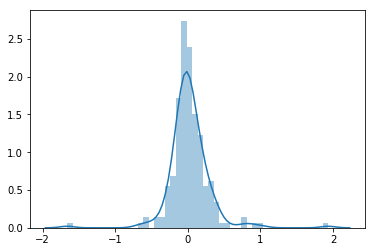

In [43]:
sns.distplot(np.exp(prediction)- np.exp(y_test.reshape(-1, 1)), norm_hist=True)

###### ToDo: Residual Analysis